# Import libaries


In [1]:
!pip install skops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 2.7 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tempfile import mkdtemp, mkstemp

import skops.io as sio
from skops import card, hub_utils

# Load datasets

In [3]:
mpl_df = pd.read_csv("/content/mpl_id_s14.csv")
attributes_df = pd.read_csv("/content/mlbb_heroes_attribute.csv")

# Drop unused columns

In [4]:
# drop unused columns
mpl_df.drop(columns=['no','week','date','match','game','match_length','blue_team','red_team'], inplace=True)
attributes_df.drop(columns=['id','main_role','secondary_role','main_damage_type'], inplace=True)

# Def functions to feature enginering

In [5]:
# Function to add sum attributes for each side
def calculate_side_features(mpl_df, attribute_df):
    # Create a hero mapping dictionary for fast lookups
    attribute_dict = attribute_df.set_index('hero')[['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']].to_dict('index')

    # Internal function to calculate the sum of attributes from one side (blue or red)
    def sum_attributes(row, side):
        positions = ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']
        features = ['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']
        side_sums = {f"{side}_{feature}": 0 for feature in features}

        for pos in positions:
            hero = row[f"{side}_{pos}"]
            if hero in attribute_dict:
                for feature in features:
                    side_sums[f"{side}_{feature}"] += attribute_dict[hero][feature]

        return pd.Series(side_sums)

    # Apply the above function to each row in mpl_df
    blue_features = mpl_df.apply(lambda row: sum_attributes(row, 'blue'), axis=1)
    red_features = mpl_df.apply(lambda row: sum_attributes(row, 'red'), axis=1)

    # Merge the results into mpl_df
    mpl_df = pd.concat([mpl_df, blue_features, red_features], axis=1)

    # Calculate the total power spike for each side
    mpl_df['blue_total_power_spike'] = mpl_df[['blue_early', 'blue_mid', 'blue_late']].sum(axis=1)
    mpl_df['red_total_power_spike'] = mpl_df[['red_early', 'red_mid', 'red_late']].sum(axis=1)

    return mpl_df

In [6]:
# Functions for feature engineering on DataFrame
def perform_feature_engineering(mpl_df):
    # Feature engineering based on attribute differences
    mpl_df['durability_diff'] = mpl_df['blue_durability'] - mpl_df['red_durability']
    mpl_df['offense_diff'] = mpl_df['blue_offense'] - mpl_df['red_offense']
    mpl_df['control_effects_diff'] = mpl_df['blue_control_effects'] - mpl_df['red_control_effects']
    mpl_df['difficulty_diff'] = mpl_df['blue_difficulty'] - mpl_df['red_difficulty']
    mpl_df['power_spike_diff'] = mpl_df['blue_total_power_spike'] - mpl_df['red_total_power_spike']

    # Average value for role per team
    mpl_df['blue_avg_durability'] = mpl_df['blue_durability'] / 5
    mpl_df['red_avg_durability'] = mpl_df['red_durability'] / 5
    mpl_df['blue_avg_offense'] = mpl_df['blue_offense'] / 5
    mpl_df['red_avg_offense'] = mpl_df['red_offense'] / 5

    # Aggressiveness score
    mpl_df['blue_aggressiveness_score'] = mpl_df['blue_offense'] / mpl_df['blue_durability']
    mpl_df['red_aggressiveness_score'] = mpl_df['red_offense'] / mpl_df['red_durability']

    # Early-mid and mid-late comparison for the blue team
    mpl_df['blue_early_mid_ratio'] = np.where(mpl_df['blue_mid'] == 0, 1, mpl_df['blue_early'] / mpl_df['blue_mid'])
    mpl_df['blue_mid_late_ratio'] = np.where(mpl_df['blue_late'] == 0, 1, mpl_df['blue_mid'] / mpl_df['blue_late'])

    # Early-mid and mid-late comparison for the red team
    mpl_df['red_early_mid_ratio'] = np.where(mpl_df['red_mid'] == 0, 1, mpl_df['red_early'] / mpl_df['red_mid'])
    mpl_df['red_mid_late_ratio'] = np.where(mpl_df['red_late'] == 0, 1, mpl_df['red_mid'] / mpl_df['red_late'])

    # Drop unused position columns
    mpl_df.drop(columns=[
        'blue_explaner', 'blue_jungler', 'blue_midlaner', 'blue_goldlaner', 'blue_roamer',
        'red_explaner', 'red_jungler', 'red_midlaner', 'red_goldlaner', 'red_roamer'
    ], inplace=True)

    # Drop unnecessary columns for the model
    mpl_df = mpl_df.drop(columns=[
        'blue_durability', 'blue_offense', 'blue_control_effects', 'blue_difficulty',
        'red_durability', 'red_offense', 'red_control_effects', 'red_difficulty',
        'blue_total_power_spike',
        'blue_early', 'blue_mid', 'blue_late',
        'red_total_power_spike',
        'red_early', 'red_mid', 'red_late'
    ])

    return mpl_df

# Feature enginering

In [7]:
# calculate mpl_df and attributes_df
mpl_attr_df = calculate_side_features(mpl_df, attributes_df)
mpl_attr_df.head()

blue_explaner blue_jungler blue_midlaner blue_goldlaner blue_roamer  \
0         Edith       Julian        Luo Yi         Moskov    Minotaur   
1        Thamuz        Nolan     Valentina         Harith    Minotaur   
2         Hylos       Julian     Valentina         Claude       Edith   
3        X.Borg       Julian     Valentina         Moskov      Arlott   
4       Paquito       Julian     Valentina         Moskov       Hylos   

  red_explaner red_jungler red_midlaner red_goldlaner red_roamer  ...  \
0       Arlott       Roger    Valentina        Harith       Chou  ...   
1       Arlott         Joy       Vexana         Roger      Edith  ...   
2         Ruby       Nolan       Vexana        Moskov     Khufra  ...   
3        Hylos       Roger        Zhask        Claude  Guinevere  ...   
4       X.Borg       Roger      Novaria        Harith  Guinevere  ...   

  blue_late  red_durability  red_offense  red_control_effects  red_difficulty  \
0         3              26           27                   23              30   
1         1              24           29                   22              23   
2         2              25           25                   32              21   
3         2              24           27                   21              22   
4         1              25           26                   13              24   

   red_early  red_mid  red_late  blue_total_power_spike  red_total_power_spike  
0          3        3         2                       8                      8  
1          2        4         2                       8                      8  
2          3        3         1                       9                      7  
3          2        4         3                       8                      9  
4          1        5         4                       7                     10  

[5 rows x 27 columns]

In [8]:
# feature enginering
mpl_df_transformed = perform_feature_engineering(mpl_attr_df)
mpl_df_transformed = mpl_df_transformed.round(3)
mpl_df_transformed.head()

result  durability_diff  offense_diff  control_effects_diff  \
0    RED                1            -1                    12   
1   BLUE                5            -4                    -1   
2   BLUE                6             1                     2   
3    RED                3             3                     6   
4   BLUE                4             2                    20   

   difficulty_diff  power_spike_diff  blue_avg_durability  red_avg_durability  \
0              -11                 0                  5.4                 5.2   
1                4                 0                  5.8                 4.8   
2                1                 2                  6.2                 5.0   
3                2                -1                  5.4                 4.8   
4                2                -3                  5.8                 5.0   

   blue_avg_offense  red_avg_offense  blue_aggressiveness_score  \
0               5.2              5.4                      0.963   
1               5.0              5.8                      0.862   
2               5.2              5.0                      0.839   
3               6.0              5.4                      1.111   
4               5.6              5.2                      0.966   

   red_aggressiveness_score  blue_early_mid_ratio  blue_mid_late_ratio  \
0                     1.038                 0.667                  1.0   
1                     1.208                 0.750                  4.0   
2                     1.000                 0.750                  2.0   
3                     1.125                 1.000                  1.5   
4                     1.040                 1.000                  3.0   

   red_early_mid_ratio  red_mid_late_ratio  
0                  1.0               1.500  
1                  0.5               2.000  
2                  1.0               3.000  
3                  0.5               1.333  
4                  0.2               1.250

# Split dataset

In [9]:
X = mpl_df_transformed.drop(columns=['result'])  # All columns except 'result'
y = mpl_df_transformed['result']  # target column

In [10]:
# Split dataset 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [11]:
# Check the size of each dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 159
Test set size: 53


In [12]:
y_train.value_counts()

result
RED     80
BLUE    79
Name: count, dtype: int64

# Train model

In [13]:
# Train model with Random Forest
model = RandomForestClassifier(
    random_state=91,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=8,
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=8, n_estimators=50,
                       random_state=91)

# Inference

In [14]:
# Make predictions on test data
y_pred = model.predict(X_test)

In [15]:
print(y_pred)
print(y_test.values)

['BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'RED' 'RED' 'RED' 'RED'
 'RED' 'RED' 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'BLUE' 'BLUE' 'BLUE' 'BLUE'
 'RED' 'RED' 'BLUE' 'BLUE' 'BLUE' 'BLUE' 'RED' 'BLUE' 'BLUE' 'RED' 'BLUE'
 'BLUE' 'BLUE' 'RED' 'RED' 'RED' 'RED' 'BLUE' 'RED' 'RED' 'RED' 'BLUE'
 'BLUE' 'BLUE' 'RED' 'RED' 'BLUE' 'BLUE' 'BLUE' 'RED' 'RED']
['BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE'
 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'BLUE' 'RED'
 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'BLUE'
 'RED' 'RED' 'BLUE' 'BLUE' 'RED' 'RED' 'BLUE' 'RED' 'RED' 'BLUE' 'BLUE'
 'BLUE' 'BLUE' 'BLUE' 'RED' 'BLUE' 'BLUE' 'BLUE' 'RED' 'RED']


In [16]:
# accuration
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=model.classes_)
print('Confusion Matrix:')
print(cm)
print()

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.70

Confusion Matrix:
[[18  9]
 [ 7 19]]

Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



# Initialize a local repository

In [18]:
# _, pkl_name = mkstemp(prefix="skops-", suffix=".pkl")
# local_repo = mkdtemp(prefix="skops-")

# with open(pkl_name, mode="bw") as f:
#     sio.dump(model, file=f)

pkl_name = "model.pkl"
local_repo = "mpl-id-s14-prediction"

with open(pkl_name, mode="bw") as f:
    sio.dump(model, file=f)

hub_utils.init(
    model=pkl_name,
    requirements=[f"scikit-learn={sklearn.__version__}"],
    dst=local_repo,
    task="tabular-classification",
    data=X_test,
)

if "__file__" in locals():  # __file__ not defined during docs built
    # Add this script itself to the files to be uploaded for reproducibility
    hub_utils.add_files(__file__, dst=local_repo)

# Create model card

In [19]:
model_card = card.Card(model, metadata=card.metadata_from_config(Path(local_repo)))

In [20]:
limitations = ("This model is only trained with MPL ID Season 14 data")
model_description = (
    "This is a RandomForestClassifier model trained on mpl_id_s14 dataset."
)
model_card_authors = "z4fL"
model_card.add(
    folded=False,
    **{
        "Model Card Authors": model_card_authors,
        "Limitations": limitations,
        "Model description": model_description,
    },
)

Card(
  model=RandomForestClassifier(max_depth=2..., n_estimators=50, random_state=91),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=model.pkl,
  metadata.widget=[{...}],
  Model description=This is a RandomForestClassi...rained on mpl_id_s14 dataset.,
  Model description/Training Procedure/Hyperparameters=TableSection(19x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model Card Authors=z4fL,
  Limitations=This model is only trained with MPL ID Season 14 data,
)

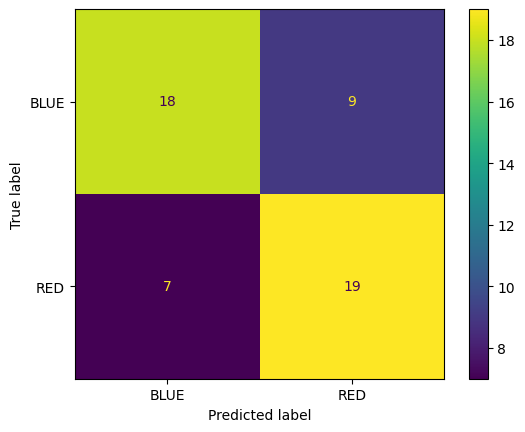

In [17]:
# create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# save the plot
plt.savefig(Path(local_repo) / "confusion_matrix.png")

In [21]:
# the plot will be written to the model card under the name confusion_matrix
# we pass the path of the plot itself
model_card.add_plot(confusion_matrix="confusion_matrix.png")

Card(
  model=RandomForestClassifier(max_depth=2..., n_estimators=50, random_state=91),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=model.pkl,
  metadata.widget=[{...}],
  Model description=This is a RandomForestClassi...rained on mpl_id_s14 dataset.,
  Model description/Training Procedure/Hyperparameters=TableSection(19x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model Card Authors=z4fL,
  Limitations=This model is only trained with MPL ID Season 14 data,
  confusion_matrix=PlotSection(confusion_matrix.png),
)

<Figure size 640x480 with 0 Axes>

In [22]:
# save the card
model_card.save(Path(local_repo) / "README.md")

# Push repository

In [ ]:
# if the repository doesn't exist remotely on the Hugging Face Hub, it will be created when we set create_remote to True
repo_id = "z4fL/prediction-win-mpl-id-s14"
hub_utils.push(
    repo_id=repo_id,
    source=local_repo,
    token="",
    commit_message="initial commit",
)